## Matrice Valore/Volume

In [92]:
# procedo con la creazione della matrice valore-volume per segmentare i prodotti in base a queste due caratteristiche
# creazione del df con prodotto e rispettivo fatturato e unità stimate vendute
product_value_volume = (
    df.groupby('ProductID').agg(TotalSales=('OutletSales', 'sum'),TotalEUS=('EstimatedUnitsSold', 'sum')).reset_index())

In [93]:
# definisco le soglie utilizzando la mediana (per essere meno sensibile rispetto agli outlier)
value_threshold = product_value_volume['TotalSales'].median()
volume_threshold = product_value_volume['TotalEUS'].median()

In [94]:
volume_threshold

82.95

In [95]:
# assegno i quadranti in base ai valori in modo da individuare le classi di prodotto
def assign_quadrant(row):
    if row['TotalSales'] >= value_threshold and row['TotalEUS'] >= volume_threshold:
        return 'High Value – High Volume'
    elif row['TotalSales'] >= value_threshold and row['TotalEUS'] < volume_threshold:
        return 'High Value – Low Volume'
    elif row['TotalSales'] < value_threshold and row['TotalEUS'] >= volume_threshold:
        return 'Low Value – High Volume'
    else:
        return 'Low Value – Low Volume'

product_value_volume['Quadrant'] = product_value_volume.apply(assign_quadrant, axis=1)

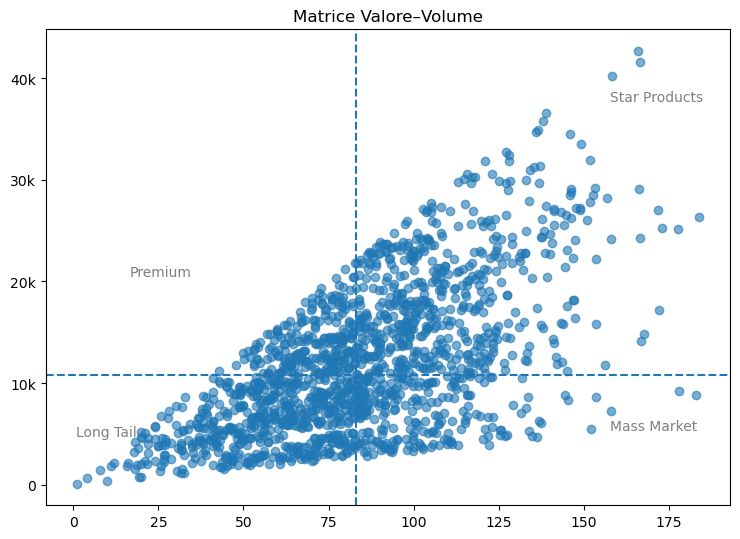

In [96]:
plt.figure(figsize=(7.5, 5.5))

plt.scatter(
    product_value_volume['TotalEUS'],
    product_value_volume['TotalSales'],
    alpha=0.6)

ax = plt.gca()
format_sales_axis(ax, axis='y')
plt.axhline(value_threshold, linestyle='--')
plt.axvline(volume_threshold, linestyle='--')

plt.xlabel('')
plt.ylabel('')
plt.title('Matrice Valore–Volume')

plt.text(volume_threshold*1.9, value_threshold*3.5, 'Star Products', alpha=0.5)
plt.text(volume_threshold*0.2, value_threshold*1.9, 'Premium', alpha=0.5)
plt.text(volume_threshold*1.9, value_threshold*0.5, 'Mass Market', alpha=0.5)
plt.text(volume_threshold*0.01, value_threshold*0.45, 'Long Tail', alpha=0.5)
plt.tight_layout()
plt.show()

In [97]:
# I prodotti sono stati segmentati in una matrice valore–volume, evidenziando le quattro principali tipologie di performance
# da questo grafico non emergono prodotti che è possibile definire Premium (ovvero con poche unità vendute 
# ma grande fatturato), invece è facile individuare i due mass market in basso a destra, 
# così come i 3 prodotti star in alto a destra; in basso a sinistra ci sono i prodotti con volumi e fatturato minore, 
# degni di un'analisi ad hoc per capire se ci sono le condizioni per tenerli nell'assortimento oppure no.
# Da osservare anche il prodotto a destra nella parte centrale del grafico (area Star Products) che sembra essere il più venduto
# e riporta un fatturato di molto superiore ai mass market con stessi volumi di vendita

In [98]:
# creo una tabella di sintesi per avere una visione d'insieme su ogni quadrante
quadrant_summary = (
    product_value_volume.groupby('Quadrant').agg(
        SKU=('ProductID', 'nunique'),TotalSales=('TotalSales', 'sum'),TotalEUS=('TotalEUS', 'sum')).reset_index())

# quote percentuali
quadrant_summary['%_SKU']= (quadrant_summary['SKU']/quadrant_summary['SKU'].sum()*100).round(2)

quadrant_summary['%_Sales'] = (quadrant_summary['TotalSales'] /quadrant_summary['TotalSales'].sum() * 100).round(2)

quadrant_summary['%_EUS'] = (quadrant_summary['TotalEUS'] /quadrant_summary['TotalEUS'].sum() * 100).round(2)

quadrant_summary

,Quadrant,SKU,TotalSales,TotalEUS,%_SKU,%_Sales,%_EUS
0,High Value – High Volume,546,10367236.08,60445.05,35.02,55.76,45.98
1,High Value – Low Volume,234,3293653.71,16499.44,15.01,17.72,12.55
2,Low Value – High Volume,234,1688254.26,23861.97,15.01,9.08,18.15
3,Low Value – Low Volume,545,3241981.47,30666.98,34.96,17.44,23.33


In [99]:
# la fascia High Value - High Volume è il cuore economico dell'assortimento, il 35% degli SKU genera il 55.7% del fatturato e 
# il 45.9% dei volumi. Questo suggerisce che i prodotti al suo interno appartengono prevalentemente a categorie di largo consumo 
# ad alta rotazione e fascia di prezzo elevata
# => proteggere con strategie di pricing, visibilità, etc.

# la fascia High Value - Low Volume genera il 17.7% del fatturato nonostante sia il 15% degli SKU
# => pricing selettivo, gestione mirata

# la fascia Low Value – High Volume genera solamente il 9% del fatturato (15% degli SKU) 
# => analisi dei costi

# la fascia Low Value – Low Volume è rappresentata dal 35% degli SKU, genera il 17.4% del fatturato e il 23.3% del volume
# => razionalizzazione per categoria/store, analisi di assortimento, etc.

In [100]:
# metto in ordine i prodotti per visualizzare i top e i worst performer
product_value_volume.sort_values(['Quadrant', 'TotalSales'],ascending=[True, False])

,ProductID,TotalSales,TotalEUS,Quadrant
1210,FDY55,42661.81,166.05,High Value – High Volume
156,FDA15,41584.54,166.62,High Value – High Volume
1230,FDZ20,40185.02,158.16,High Value – High Volume
359,FDF05,36555.75,139.03,High Value – High Volume
148,FDA04,35741.49,137.94,High Value – High Volume
...,...,...,...,...
777,FDQ04,784.31,19.86,Low Value – Low Volume
379,FDF38,771.66,19.23,Low Value – Low Volume
1200,FDY43,673.79,3.97,Low Value – Low Volume
1474,NCR42,332.90,9.86,Low Value – Low Volume


### Star Products

In [101]:
# focus sugli star products
star_products = product_value_volume[product_value_volume['Quadrant'] == 'High Value – High Volume'
].sort_values('TotalSales', ascending=False)

star_products_enriched = (df.merge(star_products[['ProductID']],on='ProductID')
                        .groupby(['ProductID', 'ProductType', 'PriceBand'],observed=True)
                        .agg(TotalSales=('OutletSales', 'sum'),TotalUnits=('EstimatedUnitsSold', 'sum'))
                        .reset_index().sort_values('TotalSales', ascending=False))

star_products_enriched.head(11)

,ProductID,ProductType,PriceBand,TotalSales,TotalUnits
419,FDY55,Fruits and Vegetables,High,42661.81,166.05
45,FDA15,Dairy,High,41584.54,166.62
427,FDZ20,Fruits and Vegetables,High,40185.02,158.16
107,FDF05,Frozen Foods,High,36555.75,139.03
42,FDA04,Frozen Foods,High,35741.49,137.94
178,FDK03,Dairy,High,34843.98,136.45
506,NCQ06,Household,High,34680.20,136.09
509,NCQ53,Health and Hygiene,High,34508.41,146.10
174,FDJ55,Meat,High,33531.01,149.13
93,FDD44,Fruits and Vegetables,High,32723.41,127.10


In [102]:
# I prodotti Star appartengono principalmente alle categorie Fruits and Vegetables, Dairy e Frozen Foods
# mantengono volumi consistenti (appartengono a categoria di largo consumo) significa che il prezzo è accettato dal mercato
# e che la domanda è stabile => mantenere alta disponibilità, evitare sconti aggressivi e out-of-stock

In [103]:
# confronto le caratteristiche del quadrante Star Products con i top3 
star_products_enriched[['TotalSales', 'TotalUnits']].describe()

,TotalSales,TotalUnits
count,546.000000,546.000000
mean,18987.611868,110.705220
std,5742.121944,19.874205
min,10872.500000,82.950000
25%,14373.282500,95.867500
50%,17911.685000,105.950000
75%,22795.167500,122.102500
max,42661.810000,183.840000


In [104]:
star_products_enriched.head(3)

,ProductID,ProductType,PriceBand,TotalSales,TotalUnits
419,FDY55,Fruits and Vegetables,High,42661.81,166.05
45,FDA15,Dairy,High,41584.54,166.62
427,FDZ20,Fruits and Vegetables,High,40185.02,158.16


In [105]:
# da questo confronto noto che i top3 hanno un fattore moltiplicativo di 2.3 volte il fatturato mediano degli altri
# prodotti dello stesso quadrante (High Value – High Volume) e un volume maggiore del 52%.
# => sono i driver principali (come si nota dalla matrice valore/volume) su entrambi gli aspetti analizzati

In [106]:
# verifico la distribuzione del fatturato dei top3 star per OutletType
df[df['ProductID'].isin(['FDY55', 'FDA15', 'FDZ20'])].groupby(['ProductID', 'OutletType'])['OutletSales'].sum()

ProductID  OutletType       
FDA15      Grocery Store          498.02
           Supermarket Type1    28636.06
           Supermarket Type2     5976.22
           Supermarket Type3     6474.24
FDY55      Grocery Store          257.00
           Supermarket Type1    31610.86
           Supermarket Type2     1541.99
           Supermarket Type3     9251.96
FDZ20      Grocery Store          508.67
           Supermarket Type1    28231.25
           Supermarket Type3    11445.10
Name: OutletSales, dtype: float64

In [107]:
# FDZ20 vende meglio nei Grocery Store e nei Type 3 rispetto agli altri top di gamma.
# FDY55 ha il primato nei Type1 mentre FDA15 lo ha nei Type2.
# da notare la completa assenza di FDZ20 dai Type2 (che compongono il 10% dei volumi stimati) 
# => analisi delle cause, possibile domanda non soddisfatta!

In [108]:
# verifico la distribuzione del fatturato per Outlet
df[df['ProductID'].isin(['FDY55', 'FDA15', 'FDZ20'])].groupby(['ProductID', 'OutletID'])['OutletSales'].sum().unstack()

OutletID,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
ProductID,,,,,,,,,,
FDA15,498.02,6474.24,5976.22,5976.22,NaN,6474.24,6474.24,5976.22,NaN,3735.14
FDY55,NaN,7452.97,NaN,1541.99,257.0,9251.96,4111.98,8994.96,4625.98,6424.97
FDZ20,508.67,6867.06,2543.36,NaN,NaN,11445.10,5849.72,6358.39,3815.03,2797.69


In [109]:
# escludendo Out010 e Out019 (con fatturato con ordine di grandezza non paragonabile agli altri) si nota che FDA15 non ha vendite
# in Out046, FDY55 in Out017 e FDZ20 in Out018. Suggerisco di indagare sulle cause per capire se ci sono potenziali di mercato.
# i top3 reagiscono diversamente allo stesso outlet: FDY55 performa molto bene in OUT027 e OUT045;
# FDZ20 ha picchi in OUT027 e OUT013; FDA15 è più bilanciato tra OUT013 / OUT017 / OUT027
# mostrando sensibilità al contesto di vendita => strategie assortitive e di layout specifiche per store.

### Mass Market

In [110]:
# focus sui mass market
mass_market_products = product_value_volume[product_value_volume['Quadrant'] == 'Low Value – High Volume'
].sort_values('TotalEUS', ascending=False)

mass_market_products_with_cat = (mass_market_products.merge(
        df[['ProductID', 'ProductType']].drop_duplicates(),on='ProductID',how='left'))

mass_market_products_with_cat.head(5)

,ProductID,TotalSales,TotalEUS,Quadrant,ProductType
0,FDO19,8845.81,183.07,Low Value – High Volume,Fruits and Vegetables
1,FDW13,9192.03,177.90,Low Value – High Volume,Canned
2,FDO32,7270.52,157.98,Low Value – High Volume,Fruits and Vegetables
3,NCO54,8620.78,153.49,Low Value – High Volume,Household
4,DRF25,5492.85,152.01,Low Value – High Volume,Soft Drinks


In [111]:
# i top products per i Mass Market fanno parte delle categorie Fruits and Vegetables e Canned
# Questi prodotti guidano i volumi, mantengono rotazione elevata ma non sono pensati per massimizzare il fatturato unitario
# devono essere presenti in assortimento perchè appartengono a categorie alimentari di base che portano 
# l'acquirente ad entrare negli store (categoria core assortment) => bundle, cross-selling evitare out-of-stock

In [112]:
# verifico la distribuzione dei volumi per OutletType
mass_market_ids = ['FDO19','FDW13','FDO32','NCO54','DRF25']

mass_market_outlettype_pct = (df[df['ProductID'].isin(mass_market_ids)]
    .groupby(['ProductID', 'OutletType'], observed=True)['EstimatedUnitsSold'].sum().reset_index())

# totale volumi per prodotto
total_units_per_product = (mass_market_outlettype_pct.groupby('ProductID')['EstimatedUnitsSold'].transform('sum'))

# calcolo percentuale
mass_market_outlettype_pct['VolumeShare_%'] = (mass_market_outlettype_pct['EstimatedUnitsSold'] / total_units_per_product * 100)

mass_market_outlettype_pct.sort_values(['ProductID', 'VolumeShare_%'], ascending=[True, False])

,ProductID,OutletType,EstimatedUnitsSold,VolumeShare_%
1,DRF25,Supermarket Type1,115.64,76.073943
2,DRF25,Supermarket Type3,34.34,22.590619
0,DRF25,Grocery Store,2.03,1.335438
4,FDO19,Supermarket Type1,119.77,65.423062
6,FDO19,Supermarket Type3,46.14,25.203474
5,FDO19,Supermarket Type2,15.22,8.313760
3,FDO19,Grocery Store,1.94,1.059704
7,FDO32,Supermarket Type1,115.96,73.401696
8,FDO32,Supermarket Type2,22.56,14.280289
9,FDO32,Supermarket Type3,19.46,12.318015


In [113]:
# DRF25 non presenta volumi nei Type2 (10% dei volumi totali) => analisi cause, opportunità di test assortitivo nei Type2
# DRF25 al contempo ha il Volume% più alto nei Type1
# FDW13 ha il Volume% più alto nei Grocery, dimostrandosi un prodotto appetibile a prescindere dall'outlet type 
# NCO54 ha il Volume% più alto nei Type2 e nei Type3 e il più basso nei Type1, dimostrando di essere un prodotto
# con volumi dipendenti dalla tipologia di outlet

In [114]:
# verifico la distribuzione dei volumi per Outlet
df[df['ProductID'].isin(['FDO19','FDW13','FDO32','NCO54','DRF25'])].groupby(
    ['ProductID', 'OutletID'])['EstimatedUnitsSold'].sum().unstack()

OutletID,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
ProductID,,,,,,,,,,
DRF25,NaN,30.42,NaN,NaN,2.03,34.34,32.62,17.81,13.63,21.16
FDO19,1.94,28.87,19.73,15.22,NaN,46.14,20.72,11.11,16.10,23.24
FDO32,NaN,24.63,24.37,22.56,NaN,19.46,9.14,18.35,25.44,14.03
FDW13,6.07,17.47,5.08,18.21,4.11,47.27,26.41,13.41,22.74,17.13
NCO54,NaN,5.80,9.96,24.17,3.09,43.81,NaN,27.02,12.91,26.73


In [115]:
# escludendo Out010 e Out019 (volume con ordine di grandezza non paragonabile agli altri) si nota che DRF25 non presenta 
# vendite in due store distinti => approfondire cause
# FDW13 è l'unico tra i best seller del quadrante ad avere volumi di vendita in tutti gli Outlet

### Hybrid Products

In [116]:
# Dalla matrice valore/volume avevamo osservato due prodotti nel quadrante Star con volumi tra i maggiori
# ma con fatturato inferiore ai top del quadrante. 
# Questi prodotti hanno una performance ibrida e per questo meritano un'analisi ad hoc

In [117]:
median_sales = product_value_volume['TotalSales'].median()
median_units = product_value_volume['TotalEUS'].median()

print(f"Il fatturato mediano è {median_sales:.2f}, mentre il volume mediano è {median_units:.2f}")

Il fatturato mediano è 10785.96, mentre il volume mediano è 82.95


In [118]:
# identificazione degli hybrid products
hybrid_products = product_value_volume[
    (product_value_volume['TotalEUS'] > median_units) &
    (product_value_volume['TotalSales'] > median_sales) &
    (product_value_volume['TotalEUS'] > product_value_volume['TotalEUS'].quantile(0.998))
    ].sort_values(by='TotalEUS', ascending=False)

print(hybrid_products)

     ProductID  TotalSales  TotalEUS                  Quadrant
1383     NCL31    26339.05    183.84  High Value – High Volume
601      FDL34    25124.62    177.80  High Value – High Volume


In [119]:
# ora li confrontiamo con i top 3 mass market
comparison = product_value_volume[product_value_volume['ProductID'].isin(
        list(hybrid_products['ProductID']) +
        list(mass_market_products['ProductID'].head(3)))].sort_values(by='TotalEUS', ascending=False)
comparison

,ProductID,TotalSales,TotalEUS,Quadrant
1383,NCL31,26339.05,183.84,High Value – High Volume
702,FDO19,8845.81,183.07,Low Value – High Volume
1077,FDW13,9192.03,177.90,Low Value – High Volume
601,FDL34,25124.62,177.80,High Value – High Volume
712,FDO32,7270.52,157.98,Low Value – High Volume


In [120]:
# Dal confronto si vede che sono il primo e il quarto prodotto con volume stimato maggiore, quindi assolutamente
# paragonabili ai mass market ma con valore unitario superiore. 
# Date queste caratteristiche, possiamo definirli Mass Market Premium => potenziali leve strategiche per ottimizzazione mix vendita

### Long Tail

In [121]:
# focus sulla Long Tail
long_tail_sorted = (product_value_volume[product_value_volume['Quadrant'] == 'Low Value – Low Volume']
    .sort_values('TotalSales', ascending=True))

long_tail_sorted.head()

,ProductID,TotalSales,TotalEUS,Quadrant
819,FDQ60,120.51,0.99,Low Value – Low Volume
1474,NCR42,332.90,9.86,Low Value – Low Volume
1200,FDY43,673.79,3.97,Low Value – Low Volume
379,FDF38,771.66,19.23,Low Value – Low Volume
777,FDQ04,784.31,19.86,Low Value – Low Volume


In [122]:
# definisco una soglia sotto la quale vengono individuati i prodotti candidati alla razionalizzazione
rationalization_candidates = long_tail_sorted[(long_tail_sorted['TotalEUS'] < 0.2 * median_units) &
    (long_tail_sorted['TotalSales'] < 0.2 * median_sales)]

rationalization_candidates

,ProductID,TotalSales,TotalEUS,Quadrant
819,FDQ60,120.51,0.99,Low Value – Low Volume
1474,NCR42,332.90,9.86,Low Value – Low Volume
1200,FDY43,673.79,3.97,Low Value – Low Volume
46,DRF48,1496.72,7.95,Low Value – Low Volume
713,FDO33,1821.63,15.79,Low Value – Low Volume
945,FDT35,1845.60,11.01,Low Value – Low Volume
1173,FDY09,2101.27,12.06,Low Value – Low Volume
1006,FDU48,2109.26,16.02,Low Value – Low Volume


In [123]:
# il confronto tra i prodotti della Long Tail e i valori mediani di volume e fatturato evidenzia un sottoinsieme di SKU 
# con performance inferiori al 20% della mediana su entrambe le metriche. 
# Questi prodotti mostrano una marginalità strutturale e rappresentano candidati naturali 
# a interventi di razionalizzazione dell’assortimento, salvo specifiche logiche di nicchia o copertura

In [124]:
# Prima di procedere con la razionalizzazione dei prodotti Long Tail individuati, verifico se i dati insoddisfacenti
# siano dovuti a mancanza di prodotto negli assortimenti dei vari outlet oppure se proprio non c'è domanda per essi.
# inserisco quindi i rapporti di fatturato/n°outlet e quantità/n°outlet
sku_ubiquity = (df.groupby('ProductID').agg(NumOutlets=('OutletID', 'nunique'),TotalSales=('OutletSales', 'sum'),
          TotalEUS=('EstimatedUnitsSold', 'sum')).reset_index())

sku_ubiquity['Sales_per_Outlet'] = (sku_ubiquity['TotalSales'] /sku_ubiquity['NumOutlets'])

sku_ubiquity['EUS_per_Outlet'] = (sku_ubiquity['TotalEUS'] /sku_ubiquity['NumOutlets'])

sku_ubiquity_asc=sku_ubiquity.sort_values('Sales_per_Outlet', ascending=True)

sku_ubiquity_asc

,ProductID,NumOutlets,TotalSales,TotalEUS,Sales_per_Outlet,EUS_per_Outlet
1474,NCR42,3,332.90,9.86,110.966667,3.286667
819,FDQ60,1,120.51,0.99,120.510000,0.990000
777,FDQ04,3,784.31,19.86,261.436667,6.620000
1124,FDX10,4,1164.48,32.66,291.120000,8.165000
1413,NCN29,5,1555.31,32.00,311.062000,6.400000
...,...,...,...,...,...,...
106,DRK23,5,27324.43,107.91,5464.886000,21.582000
1255,FDZ50,2,11025.65,60.21,5512.825000,30.105000
1011,FDU55,4,23689.83,90.94,5922.457500,22.735000
1385,NCL42,3,17886.05,72.97,5962.016667,24.323333


In [125]:
# creo una matrice decisionale che permetta di individuare quali sono i prodotti della long tail su cui occorre intervenire
# e con quali decisioni consigliate
long_tail_products = product_value_volume[product_value_volume['Quadrant'] == 'Low Value – Low Volume']

In [126]:
long_tail_ids = long_tail_products['ProductID']

long_tail_decision = sku_ubiquity[sku_ubiquity['ProductID'].isin(long_tail_ids)].copy()

In [127]:
long_tail_decision

,ProductID,NumOutlets,TotalSales,TotalEUS,Sales_per_Outlet,EUS_per_Outlet
3,DRB01,3,4554.07,24.01,1518.023333,8.003333
9,DRC12,4,8949.68,47.08,2237.420000,11.770000
10,DRC13,4,6528.17,52.40,1632.042500,13.100000
11,DRC24,2,6305.80,41.13,3152.900000,20.565000
15,DRC49,3,8484.96,58.49,2828.320000,19.496667
...,...,...,...,...,...,...
1537,NCX53,2,4112.64,28.76,2056.320000,14.380000
1546,NCY42,4,10449.73,72.26,2612.432500,18.065000
1549,NCZ05,3,2063.98,19.84,687.993333,6.613333
1553,NCZ29,4,6669.32,52.84,1667.330000,13.210000


In [128]:
# imposto una soglia minima per i rapporti fatturato/outlet e unità/outlet 
sales_thr = long_tail_decision['Sales_per_Outlet'].median()*0.35
units_thr = long_tail_decision['EUS_per_Outlet'].median()*0.35

print(f"la soglia minima per fatturato/outlet è {sales_thr:.2f}")
print(f"la soglia minima per unità/outlet è {units_thr:.2f}")

la soglia minima per fatturato/outlet è 490.45
la soglia minima per unità/outlet è 4.52


In [129]:
# definizione delle azioni consigliate
def decision_bucket(row):
    if row['Sales_per_Outlet'] < sales_thr and row['EUS_per_Outlet'] < units_thr:
        return 'Eliminare'
    elif row['Sales_per_Outlet'] >= sales_thr and row['EUS_per_Outlet'] < units_thr:
        return 'Promuovere'
    elif row['Sales_per_Outlet'] < sales_thr and row['EUS_per_Outlet'] >= units_thr:
        return 'Riprezzare'
    else:
        return 'Tenere'

long_tail_decision['Decision'] = long_tail_decision.apply(decision_bucket, axis=1)

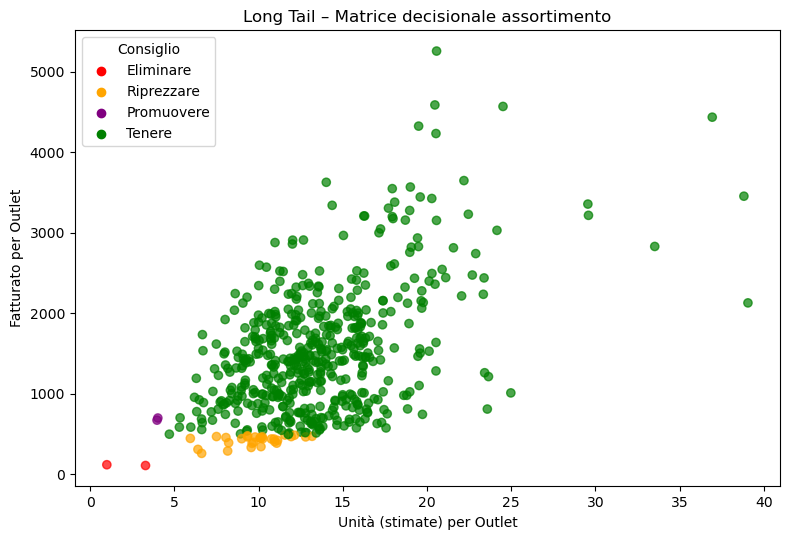

In [130]:
# visualizzazione della matrice decisionale per il quadrante della long tail
# mappa colori decisionale
decision_colors = {
    'Eliminare': 'red',
    'Riprezzare': 'orange',
    'Promuovere': 'purple',
    'Tenere': 'green'}

plt.figure(figsize=(8, 5.5))

plt.scatter(
    long_tail_decision['EUS_per_Outlet'],
    long_tail_decision['Sales_per_Outlet'],
    c=long_tail_decision['Decision'].map(decision_colors),
    alpha=0.7)

plt.xlabel('Unità (stimate) per Outlet')
plt.ylabel('Fatturato per Outlet')
plt.title('Long Tail – Matrice decisionale assortimento')

# legenda
for label, color in decision_colors.items():
    plt.scatter([], [], c=color, label=label)

plt.legend(title='Consiglio')
plt.tight_layout()
plt.show()

In [131]:
# i prodotti in rosso hanno bassi volumi e basso valore => candidati forti alla rimozione
# i prodotti in viola hanno bassi volumi e valore medio => valutare promozioni ed esposizione
# i prodotti in arancione hanno medi volumi e basso valore => prezzo basso, ottimizzare
# i prodotti in verde hanno volumi e valori superiori alla soglia minima => tenere/monitorare

In [132]:
# L’integrazione delle metriche di produttività per punto vendita consente di supportare decisioni di razionalizzazione 
# basate sulla domanda effettiva, distinguendo tra prodotti da eliminare, SKU di nicchia da preservare e 
# articoli che richiedono interventi di prezzo o promozionali 

In [133]:
# voglio visualizzare i prodotti candidati alla eliminazione
eliminate_products = long_tail_decision[long_tail_decision['Decision'] == 'Eliminare'].sort_values(
    by=['Sales_per_Outlet', 'EUS_per_Outlet'],ascending=True)

eliminate_products

,ProductID,NumOutlets,TotalSales,TotalEUS,Sales_per_Outlet,EUS_per_Outlet,Decision
1474,NCR42,3,332.90,9.86,110.966667,3.286667,Eliminare
819,FDQ60,1,120.51,0.99,120.510000,0.990000,Eliminare
